In [37]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.utils
from PIL import Image
from torchvision.models import vgg16
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

In [38]:
class Face2ComicDataset(Dataset):
    def __init__(self, photo_dir, comic_dir, transform=None):
        self.photo_dir = photo_dir
        self.comic_dir = comic_dir
        self.transform = transform
        self.filenames = sorted(os.listdir(photo_dir))

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        photo_path = os.path.join(self.photo_dir, self.filenames[idx])
        comic_path = os.path.join(self.comic_dir, self.filenames[idx])
        try:
            photo = Image.open(photo_path).convert('RGB')
            comic = Image.open(comic_path).convert('RGB')
        except Exception as e:
            print(f"Error loading: {photo_path} or {comic_path} -- {e}")
            raise
        if self.transform:
            photo = self.transform(photo)
            comic = self.transform(comic)
        return photo, comic



In [39]:
transform = transforms.Compose([
    transforms.Resize((224, 192)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

# 3. 建立資料集與 DataLoader
dataset = Face2ComicDataset("/home/user/Downloads/Comic_Style_ubuntu/Comic Style/train/input", 
                            "/home/user/Downloads/Comic_Style_ubuntu/Comic Style/train/label", transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=0)

In [40]:
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        self.encoder1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.encoder2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.encoder3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.middle = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.decoder3 = nn.Sequential(
            nn.Conv2d(512, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.decoder2 = nn.Sequential(
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.decoder1 = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 3, kernel_size=3, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))
        enc3 = self.encoder3(self.pool2(enc2))
        mid = self.middle(self.pool3(enc3))
        dec3 = self.decoder3(torch.cat([self.upconv3(mid), enc3], dim=1))
        dec2 = self.decoder2(torch.cat([self.upconv2(dec3), enc2], dim=1))
        dec1 = self.decoder1(torch.cat([self.upconv1(dec2), enc1], dim=1))
        return dec1

model = UNet()

In [41]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.L1Loss()
num_epochs = 50

for epoch in range(num_epochs):
    running_loss = 0.0
    for i, (photo, comic) in enumerate(dataloader):
        photo, comic = photo.to(device), comic.to(device)
        output = model(photo)
        loss = criterion(output, comic)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    avg_loss = running_loss / len(dataloader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.7f}")

Epoch [1/50], Loss: 0.2530858
Epoch [2/50], Loss: 0.2254858
Epoch [3/50], Loss: 0.2062092
Epoch [4/50], Loss: 0.1966640
Epoch [5/50], Loss: 0.1888141
Epoch [6/50], Loss: 0.1832008
Epoch [7/50], Loss: 0.1791898
Epoch [8/50], Loss: 0.1747304
Epoch [9/50], Loss: 0.1722648
Epoch [10/50], Loss: 0.1685897
Epoch [11/50], Loss: 0.1659573
Epoch [12/50], Loss: 0.1642925
Epoch [13/50], Loss: 0.1619449
Epoch [14/50], Loss: 0.1591687
Epoch [15/50], Loss: 0.1573729
Epoch [16/50], Loss: 0.1553621
Epoch [17/50], Loss: 0.1532898
Epoch [18/50], Loss: 0.1520802
Epoch [19/50], Loss: 0.1499056
Epoch [20/50], Loss: 0.1476945
Epoch [21/50], Loss: 0.1455495
Epoch [22/50], Loss: 0.1442678
Epoch [23/50], Loss: 0.1427532
Epoch [24/50], Loss: 0.1405993
Epoch [25/50], Loss: 0.1388862
Epoch [26/50], Loss: 0.1376369
Epoch [27/50], Loss: 0.1357119
Epoch [28/50], Loss: 0.1347694
Epoch [29/50], Loss: 0.1327249
Epoch [30/50], Loss: 0.1314876
Epoch [31/50], Loss: 0.1302755
Epoch [32/50], Loss: 0.1285926
Epoch [33/50], Lo

In [42]:
torch.save(model.state_dict(), "/home/user/Downloads/Comic_Style_ubuntu/comic_unet_model.pth")

In [43]:
#test whether the model works

model = UNet() # define UNet 

model.load_state_dict(torch.load("/home/user/Downloads/Comic_Style_ubuntu/comic_unet_model.pth", map_location="cpu"))# load in the trained model
model.eval()

transform = transforms.Compose([
    transforms.Resize((224, 192)),
    transforms.ToTensor(),
])

test_image1 = Image.open("/home/user/Downloads/Comic_Style_ubuntu/comic input test/9496.jpg").convert("RGB")
input_tensor1 = transform(test_image1).unsqueeze(0)

test_image2 = Image.open("/home/user/Downloads/Comic_Style_ubuntu/comic input test/9497.jpg").convert("RGB")
input_tensor2 = transform(test_image2).unsqueeze(0)

test_image3 = Image.open("/home/user/Downloads/Comic_Style_ubuntu/comic input test/9498.jpg").convert("RGB")
input_tensor3 = transform(test_image3).unsqueeze(0)

test_image4 = Image.open("/home/user/Downloads/Comic_Style_ubuntu/comic input test/9499.jpg").convert("RGB")
input_tensor4 = transform(test_image4).unsqueeze(0)

test_image5 = Image.open("/home/user/Downloads/Comic_Style_ubuntu/comic input test/9500.jpg").convert("RGB")
input_tensor5 = transform(test_image5).unsqueeze(0)

with torch.no_grad():
    output_tensor1 = model(input_tensor1)[0] 
output_tensor1 = output_tensor1.clamp(-1, 1)         
output_tensor1 = (output_tensor1 + 1) / 2   

with torch.no_grad():
    output_tensor2 = model(input_tensor2)[0]
output_tensor2 = output_tensor2.clamp(-1, 1)         
output_tensor2 = (output_tensor2 + 1) / 2 

with torch.no_grad():
    output_tensor3 = model(input_tensor3)[0]
output_tensor3 = output_tensor3.clamp(-1, 1)         
output_tensor3 = (output_tensor3 + 1) / 2 

with torch.no_grad():   
    output_tensor4 = model(input_tensor4)[0]
output_tensor4 = output_tensor4.clamp(-1, 1)         
output_tensor4 = (output_tensor4 + 1) / 2 

with torch.no_grad():
    output_tensor5 = model(input_tensor5)[0]    
output_tensor5 = output_tensor5.clamp(-1, 1)         
output_tensor5 = (output_tensor5 + 1) / 2 

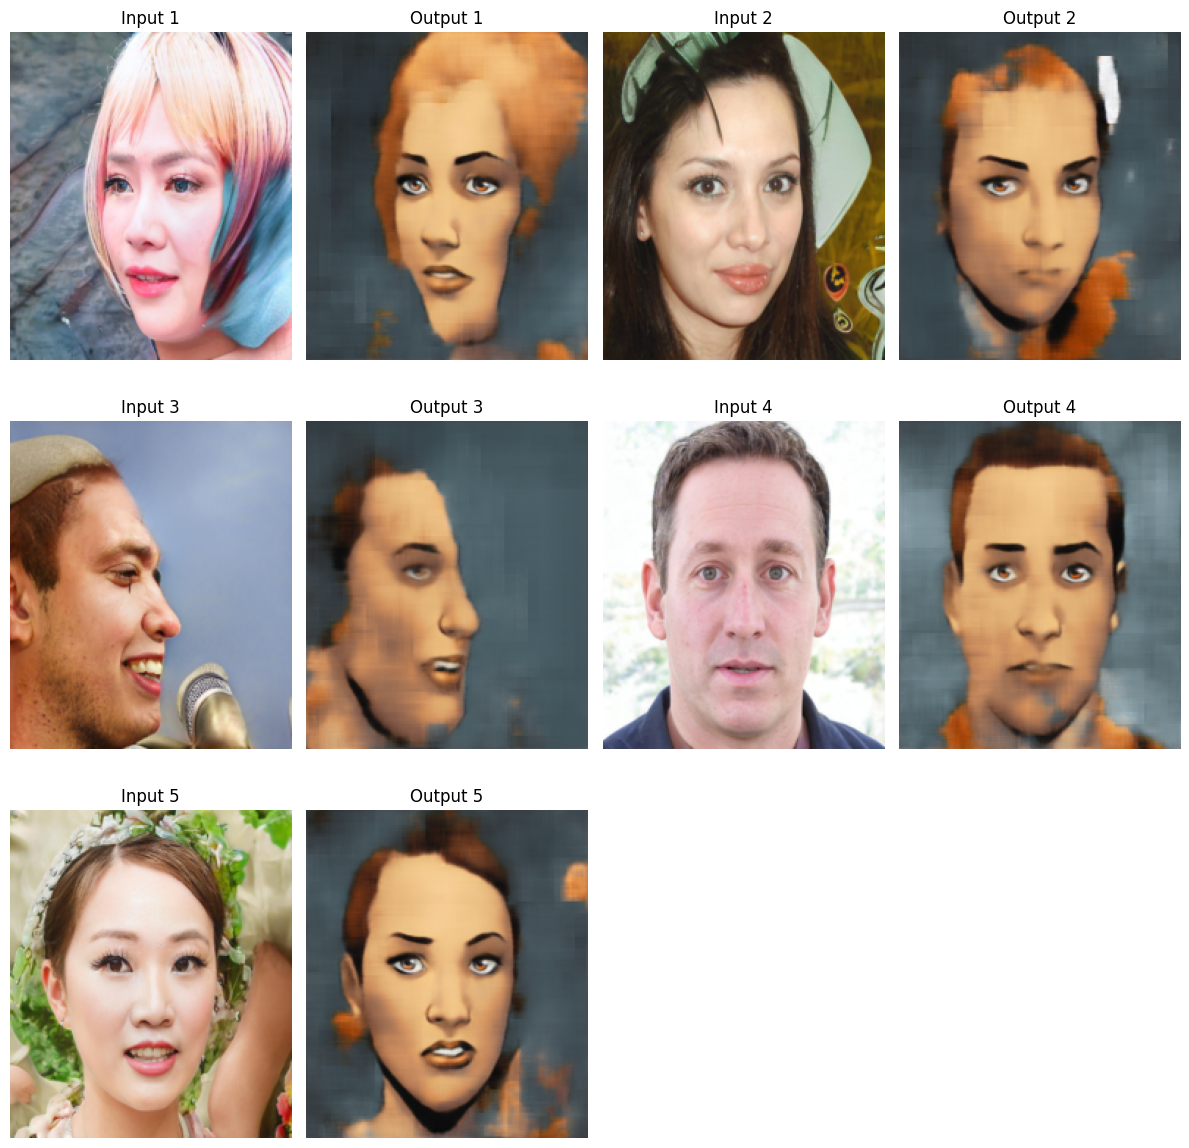

done


In [44]:
inputs = [input_tensor1, input_tensor2, input_tensor3, input_tensor4, input_tensor5]
outputs = [output_tensor1, output_tensor2, output_tensor3, output_tensor4, output_tensor5]

num_pairs = len(inputs)
cols = 2  # 每列兩組
rows = (num_pairs + cols - 1) // cols  

plt.figure(figsize=(12, 4 * rows))
for i in range(num_pairs):
    row = i // cols
    col = i % cols
    # Input
    plt.subplot(rows, cols * 2, row * cols * 2 + col * 2 + 1)
    plt.imshow(inputs[i][0].permute(1, 2, 0).cpu().numpy())
    plt.title(f"Input {i+1}")
    plt.axis('off')
    # Output
    plt.subplot(rows, cols * 2, row * cols * 2 + col * 2 + 2)
    plt.imshow(outputs[i].permute(1, 2, 0).detach().cpu().numpy())
    plt.title(f"Output {i+1}")
    plt.axis('off')
plt.tight_layout()
plt.show()

print("done")